In [24]:
from pauli import PauliSum, SiteBasis, PauliString
from hamiltonians import transverse_field_ising_model

import cvxpy as cp
import numpy as np
from scipy.sparse import csr_array
from scipy.linalg import eigvalsh, eigvals, expm, logm, sqrtm, inv
import matplotlib.pyplot as plt

<h2>Thermal Transverse Field Ising:</h2>

In [2]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def normalization(basis: SiteBasis, L: int, B: cp.Variable) -> list[cp.Constraint]:
    return [B[basis.rank('I'*L)] == 1]

def beta_independent_constraints(basis: SiteBasis, B: cp.Variable, L: int, hamil: PauliSum) -> list[cp.Constraint]:
    constraints = []
    constraints.extend(normalization(basis, L, B))
    row_ind, col_ind, data = [], [], []
    n_rows = 0
    n_cols = B.shape[0]
    for word in basis._ops:
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            row_ind.append(n_rows)
            col_ind.append(basis.rank(str(pstr)))
            data.append(np.imag(weight))
        n_rows += 1
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), shape=(n_rows, n_cols))
        constraints.append(P @ B == 0)
    return constraints

def kms(basis: SiteBasis, B: cp.Variable, hamil: PauliSum, beta: cp.Parameter, k: int):
    ops = basis._ops
    n = len(ops)
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliString(ops[i])
            pj = PauliString(ops[j])
            pstr = pi * pj
            idx = basis.rank(str(pstr))
            row_inds[idx].append(i)
            col_inds[idx].append(j)
            datas[idx].append(pi.phase(pj))
    A = cp.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)) * B[i] for i in range(n)])
    row_inds = [[] for _ in range(n)]
    col_inds = [[] for _ in range(n)]
    datas = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            pi = PauliSum(ops[i])
            pj = PauliSum(ops[j])
            psum = pi * (hamil | pj)
            if psum.is_zero():
                continue
            # Now, we have a PauliSum of terms...and also some zero locations
            # Experiments suggest that the sparsity is not much
            # Now each non-zero location is some linear combination of Pauli strings
            # in the reduced basis...how to deal with this?
            # Well, now it is a linear matrix inequality...just write as F[i] * x[i]
            # These F[i] are sparse
            for pstr, weight in psum.terms.items():
                idx = basis.rank(str(pstr))
                row_inds[idx].append(i)
                col_inds[idx].append(j)
                datas[idx].append(weight)
    C = cp.sum([csr_array((datas[i], (row_inds[i], col_inds[i])), shape=(n, n)) * B[i] for i in range(n)])
    T = 2**(-k) * beta * C
    Zs = [A.T] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    constraints = []
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    return constraints

In [39]:
L = 3
basis = SiteBasis(L)
ops = basis._ops
n = len(ops)
hamil = transverse_field_ising_model(L, 1)
beta = 1
rho = expm(-beta * hamil.to_matrix())
rho /= np.trace(rho)
A = np.zeros((n, n), dtype=complex)
B = np.zeros((n, n), dtype=complex)
C = np.zeros((n, n), dtype=complex)
for i in range(n):
    for j in range(n):
        pi = PauliSum(ops[i])
        pj = PauliSum(ops[j])
        psumA = pi * pj
        psumB = pj * pi
        psumC = pi * (hamil | pj)
        A[i, j] = np.trace(rho @ psumA.to_matrix())
        B[i, j] = np.trace(rho @ psumB.to_matrix())
        if isinstance(psumC.to_matrix(), int):
            continue
        C[i, j] = np.trace(rho @ psumC.to_matrix())
Asqrt = sqrtm(A)
Binv = inv(B)
M = beta * C - Asqrt * logm(Asqrt * Binv * Asqrt) * Asqrt
print(min(eigvalsh(M)))

-2.8141738318820377


In [3]:
def construct_problem(L: int, h: float, k: int):
    basis = SiteBasis(L, True)
    B = cp.Variable(basis.size())
    hamil = transverse_field_ising_model(L, h)
    beta = cp.Parameter(nonneg = True)
    constraints = [B >= -1, B <= 1]
    # constraints = []
    constraints.extend(beta_independent_constraints(basis, B, L, hamil))
    constraints.extend(kms(basis, B, hamil, beta, k))
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob, L):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True) / L
        E_max = maxprob.solve(accept_unknown=True) / L
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [21]:
L, h, k = 4, 1, 1
beta, minprob, maxprob = construct_problem(L, h, k)

In [22]:
betas = 1/np.linspace(0.01, 4, num = 20)
mins, maxs = solve_energy(betas, beta, minprob, maxprob, L)

Solving for T=0.01, i=0:
	E_min = -1.3065615671401607
	E_max = -1.3065458334150681
Solving for T=0.22000000000000003, i=1:
	E_min = -1.2929494641064556
	E_max = -1.2897422318834852
Solving for T=0.43000000000000005, i=2:
	E_min = -1.2783748411429507
	E_max = -1.2634496865133935
Solving for T=0.6400000000000001, i=3:
	E_min = -1.2709044094213646
	E_max = -1.2308739803626003
Solving for T=0.8500000000000001, i=4:
	E_min = -1.248826780579107
	E_max = -1.186385964940437
Solving for T=1.06, i=5:
	E_min = -1.2030945191907074
	E_max = -1.1304457811984998
Solving for T=1.2700000000000002, i=6:
	E_min = -1.1379126464171234
	E_max = -1.0670685918861071
Solving for T=1.4800000000000002, i=7:
	E_min = -1.0623750548721007
	E_max = -1.0008037840149078
Solving for T=1.6900000000000002, i=8:
	E_min = -0.9855916299044842
	E_max = -0.935087780521007
Solving for T=1.9000000000000001, i=9:
	E_min = -0.9126799780250698
	E_max = -0.8724124485749847
Solving for T=2.11, i=10:
	E_min = -0.8458519651719931
	E_m

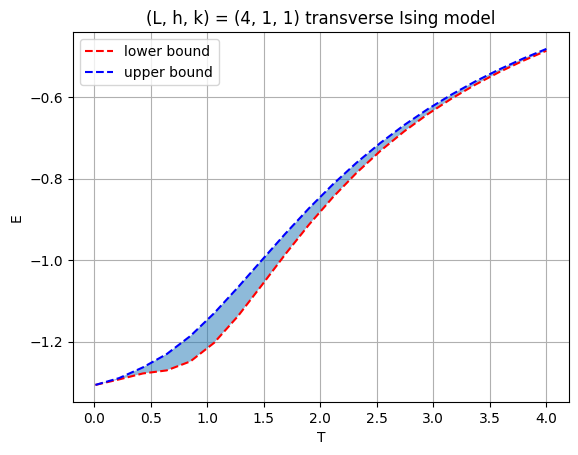

In [23]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder=2)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h, k) = ({L}, {h}, {k}) transverse Ising model')
plt.legend()
plt.grid(zorder=1)
# plt.savefig(f'ising_{L}_{h}_{k}.png',bbox_inches='tight')
plt.show()

In [24]:
np.savez(f'thermal_ising_{L}_{h}_{k}.npz',betas=betas,mins=mins,maxs=maxs)

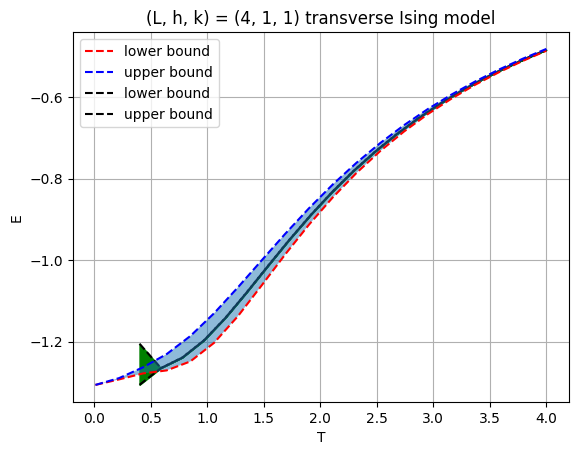

In [28]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder=4)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=5)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=5)
data = np.load(f'thermal_hseries_ising_{L}_{h}.npz')
plt.fill_between(1/data['betas'], data['mins'], data['maxs'], alpha = 1, zorder=2, color='green')
plt.plot(1/data['betas'], data['mins'],c ='black',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/data['betas'], data['maxs'],c ='black',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h, k) = ({L}, {h}, {k}) transverse Ising model')
plt.legend()
plt.grid(zorder=1)
plt.show()